In [1]:
import numpy as np
import pandas as pd
import polarDensity_helper as pc
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import LogNorm
from matplotlib.ticker import LogFormatterExponent
plt.rcParams['axes.grid'] = False 

/u2/home_u2/ems363/miniconda3/envs/jupEnv/lib/python3.9/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


# Important User Settings:

In [2]:
# root = Path("/home/ems363/Projects/ELIC_PE_PG/trajectory_version")
# chains_groups = ["POPE", "POPG"]
#root = Path("/home/ems363/Projects/ELIC_PE_PG/aggregated/")
root = Path("/home/ems363/Projects/ELIC_PE_PG/aggregated/rep1/")
#root = Path("/home/ems363/Projects/ELIC_PE_PG/liam/trajectory_version/")
chains_groups = ["POPG"]
lipids = chains_groups

In [3]:
enrich = True

# get files to use

file_list = []
for lip in lipids:
    toadd = list(root.glob(f"{lip}.dat*avg.dat") )
    file_list = np.append(file_list,toadd)

leaflets = ['low', 'upp']

In [4]:
enrichments = pd.DataFrame(index=chains_groups, columns=leaflets)
counts = pd.DataFrame(index=chains_groups, columns=leaflets)

idx = 0
for fl in file_list:
    if idx == 0:
        rad, dr, dth, theta, radius, frames, Ntheta = pc.Coord_Get(fl)

    filename = fl.name

    tmp_chain = filename.split('.')[0]
    tmp_nm = filename.split('.')[2]

    # This is a hack. The above part does not have a "flexible"
    # method to consider sim type (a, b ...)
    idx+=1
    toadd = np.loadtxt(fl, skiprows=1)
    toadd = toadd[:,3:-1]
    counts.at[tmp_chain,tmp_nm] = toadd
    enrichments.at[tmp_chain,tmp_nm] = pc._analysis_call_(fl, radius, dr, dth, frames, enrich=enrich)


In [5]:
# Optional helix locations
try:
    helices_lwr = np.loadtxt(root.joinpath("Protein_coords_lwr.dat"))
    helices_upr = np.loadtxt(root.joinpath("Protein_coords_upr.dat"))
except FileNotFoundError:
    helices_lwr = None
    helices_upr = None
    print("Protein coordinates not found")

In [6]:
#    ax = plt.subplot(111,projection="polar")
def plot_single(toplot, theta, radius, ax, vmid=1, vmin=0, vmax=2, norm=None):
    if norm is None:
        norm = pc.MidpointNormalize(midpoint=vmid,vmin=vmin,vmax=vmax)
    ax.grid(False)
    plt.axis('off')
    s = ax.pcolormesh(theta, 
                        radius, 
                        toplot,
                        cmap='RdBu',
                        norm=norm,
                        zorder=0,
                        edgecolors='face',
                        linewidth=0,
                        )
    s.set_edgecolor('face')
    
    return ax

In [7]:
#  orange   light blue   green       purple      amber      blue       red 
#"#E69F00"  "#56B4E9"  "#009E73"   "#CC79A7"   "#F5C710"  "#0072B2"  "#D55E00"  
sub = ["#E69F00", "#56B4E9", "#009E73", "#CC79A7", "#F5C710", "#0072B2", "#D55E00"]


def plot_helices(helices, colorbychain, ax, markersize=3):
    if len(np.shape(helices))==1:
        helices = np.reshape(helices, (1,len(helices)))
    for i,pro in enumerate(helices[:]):
        if colorbychain:
            colors = sub[i]
        else:
            colors = sub[:len(pro[::2])]        
        ax.scatter(np.deg2rad(pro[1::2]),
                    pro[::2],
                    color=colors,
                    linewidth=None,
                    zorder=1, 
                    s=markersize,
                    )
        
    return ax

In [ ]:
def do_plot(toplot, 
                         theta,
                         radius,
                         ax,
                         norm1,
                         the_title,
                         the_ylabel):
    

In [12]:
def polar_plot(data_in, 
               theta, 
               radius, 
               chains_groups, 
               helices_lwr=None, 
               helices_upr=None, 
               vmax=2, 
               vmid=1, 
               vmin=0, 
               colorbychain=True,
               figwidth=20,
               figheight=20):
	# plots densities
	# data_in = array/list of density data
	# theta, radius = arrays of position bins
	# chains_groups = old name, really lipids to plot

    data_in = pc.sum_reps(data_in)
    fig = plt.figure(figsize=(figwidth,figheight))
    gs1=gridspec.GridSpec(len(chains_groups),2,wspace=.15, hspace=0.15)
    plt.rcParams.update({'font.size': 10})
    norm1 = pc.MidpointNormalize(midpoint=vmid,vmin=vmin,vmax=vmax)
    cmap = plt.cm.RdBu#PuOr
    cmap.set_bad(color='black')
    grid = 0    
    for cg in chains_groups:
        for leaf in data_in.columns:
            toplot = data_in.at[cg,leaf]
            ax = plt.subplot(gs1[grid],projection="polar")
            if grid%2==0:
                ax.set_ylabel(cg)
            if grid < 2:
                ax.set_title(leaf)

            ax = plot_single(toplot, theta, radius, ax, norm=norm1)
            ax.set_xticklabels([])
            ax.set_yticklabels([])
                    
            if leaf=="Outer":
                helices = helices_upr
            else:
                helices = helices_lwr

            ax = plot_helices(helices, colorbychain, ax, markersize=50)
            
            grid = grid + 1

    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.21, .89, 0.5, 0.008])
    sm = plt.cm.ScalarMappable(cmap=cmap)
    cbar = fig.colorbar(sm, cax=cbar_ax, orientation="horizontal")
    cbar.set_ticks(np.linspace(0,1,5))
    cbar.ax.set_xticklabels([vmin, (vmin+vmid)/2, vmid, (vmid+vmax)/2, vmax])

    #plt.tight_layout()
    return fig, fig.axes

In [13]:
thetas = np.unique(theta.flatten())

In [14]:
bins = {1:(range(4,30,6), np.repeat(27.5,5)), 
        2:(range(5,30,6), np.repeat(27.5,5)),
        3:(range(4,30,6), np.repeat(32.5,5)),
        4:(range(5,30,6), np.repeat(32.5,5)),
        5:(range(4,30,6), np.repeat(22.5,5))}

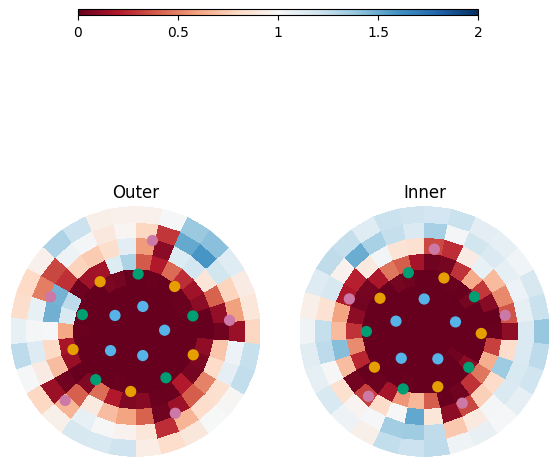

In [17]:
fig, axes = polar_plot(enrichments, 
                       theta, 
                       radius, 
                       chains_groups, 
                       helices_lwr, 
                       helices_upr, 
                       colorbychain=False, 
                       vmin=0, 
                       vmax=2, 
                       vmid=1,
                       figheight=8,
                       figwidth=8)

plt.savefig(root.joinpath("ELIC_enrichments.pdf"))
plt.show()